In [ ]:
!pip install wandb

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
import pickle
import numpy as np
import torch
from sklearn import metrics
import wandb
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import torch.optim as optim

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CustomEEGDataset(Dataset):
    def __init__(self, annotations_file, eeg_file, transform=None, target_transform=None):
        self.eeg_labels = torch.from_numpy(np.load(annotations_file).reshape(-1,1))
        self.eeg_data = torch.from_numpy(np.load(eeg_file))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.eeg_labels)

    def __getitem__(self, idx):
        label = self.eeg_labels[idx]
        eeg = self.eeg_data[idx]
        if self.transform:
            eeg = self.transform(eeg)
        if self.target_transform:
            label = self.target_transform(label)
        return eeg, label

### NEEEEEEEEEEEEEEW

In [ ]:
#DE
eeg_DE_dataset = CustomEEGDataset('/content/label_valence_no_neutral_DE.npy','/content/eeg_data_no_neutral_DE.npy' )
#trainloader = torch.utils.data.DataLoader(eeg_DE_dataset, batch_size=128,
#                                          shuffle=True, num_workers=2)

In [ ]:
#PSD
eeg_PSD_dataset = CustomEEGDataset('/content/label_valence_no_neutral_channel_first.npy','/content/eeg_data_no_neutral_PSD_channel_first.npy' )
#trainloader = torch.utils.data.DataLoader(eeg_PSD_dataset, batch_size=64,
#                                          shuffle=True, num_workers=2)

In [ ]:
# New label strategy PSD
#PSD
eeg_PSD_dataset = CustomEEGDataset('/content/label_based_on_movie_classification.npy','/content/eeg_data_no_neutral_PSD_channel_first_second_run.npy' )
#trainloader = torch.utils.data.DataLoader(eeg_PSD_dataset, batch_size=64,
#                                          shuffle=True, num_workers=2)

In [ ]:
# New label strategy DE
# New label strategy PSD
#PSD
eeg_DE_dataset = CustomEEGDataset('/content/label_based_on_movie_classification.npy','/content/eeg_data_no_neutral_DE_channel_first_second_run.npy' )
#trainloader = torch.utils.data.DataLoader(eeg_DE_dataset, batch_size=64,
#                                          shuffle=True, num_workers=2)

Batchnormalization CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_norm1 = nn.BatchNorm2d(5)
        self.batch_norm2 = nn.BatchNorm1d(16)
        #self.batch_norm3 = nn.BatchNorm2d(5)
        #self.batch_norm4 = nn.BatchNorm2d(5)
        self.conv = torch.nn.Conv2d(5, 8, (2,3),padding = 'valid')
        self.conv1 = nn.Conv2d(8, 6, (3,2), padding = 'valid')
        self.conv2 = nn.Conv2d(6, 4, (2,3), padding = 'valid')
        self.conv3 = nn.Conv2d(8, 6, (2,2), padding = 'valid')
        self.pool = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(32, 20, (3,2), padding = 'valid')
        self.conv5 = nn.Conv2d(20, 10, (2,2), padding = 'valid')
        self.fc1 = nn.Linear(120, 16)
        self.fc2 = nn.Linear(16, 1)
        #self.fc3 = nn.Linear(128, 28)
        #self.fc4 = nn.Linear(28, 1)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.relu(self.conv(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #x = F.relu(self.conv3(x))
        #x = self.pool2(F.relu(self.conv4(x)))
        #x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.batch_norm2(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        #x = self.batch_norm3(x)
        x = self.dropout2(x)
        #x = F.relu(self.fc3(x))
        #x = self.batch_norm4(x)
        #x = self.fc4(x)
        x = self.sigmoid(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  correct = 0
  train_acc = []
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = nn.functional.binary_cross_entropy(output, target)
      #loss = nn.BCELoss(output,target)
      loss.backward()
      optimizer.step()
      output = model(data)
      pred = output.round().cpu().detach().numpy()
      target = target.cpu().numpy()
      acc = metrics.accuracy_score(target,pred) #== target).float().mean()
      train_acc.append(acc)
  wandb.log({"train epoch acc": np.mean(train_acc)})
  return train_acc, loss

Net(
  (batch_norm1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Conv2d(5, 8, kernel_size=(2, 3), stride=(1, 1), padding=valid)
  (conv1): Conv2d(8, 6, kernel_size=(3, 2), stride=(1, 1), padding=valid)
  (conv2): Conv2d(6, 4, kernel_size=(2, 3), stride=(1, 1), padding=valid)
  (conv3): Conv2d(8, 6, kernel_size=(2, 2), stride=(1, 1), padding=valid)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 20, kernel_size=(3, 2), stride=(1, 1), padding=valid)
  (conv5): Conv2d(20, 10, kernel_size=(2, 2), stride=(1, 1), padding=valid)
  (fc1): Linear(in_features=120, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (dropout2): Dropou

### Intra-subject generalizability

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="CNN EEG BASELINE",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "shallow cnn new labels 6",
    "dataset": "EEG",
    "epochs": 500,
    }
)

In [ ]:
# Define the number of folds and batch size
#k_folds = 2
batch_size = 64

# Initialize the k-fold cross validation
#kf = KFold(n_splits=k_folds, shuffle=True)
# SSS instead - for bettter train/test proportion
#sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# Shufflesplit
rs = ShuffleSplit(n_splits=1, test_size=.1)
# Loop through each fold
test_idx_list = []
for fold, (train_idx, test_idx) in enumerate(rs.split(eeg_PSD_dataset)):
    print(type(train_idx[0]))
    test_idx_list.append(test_idx)
    print(type(train_idx))
    #print(len(train_idx), len(test_idx), train_idx, test_idx)
    print(f"Fold {fold + 1}")
    print("-------")
    all_accs_train = []
    all_loss_train = []
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=eeg_PSD_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )

    test_loader = DataLoader(
        dataset=eeg_PSD_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) #betas=(0.5, 0.99))
    #scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 200, gamma = 0.5)

    # Train the model on the current fold
    for i in range(30):
      for epoch in tqdm(range(1, 30)):
          train_accuracies, loss = train(model, device, train_loader, optimizer, epoch)
          all_accs_train.append(np.mean(train_accuracies))
          all_loss_train.append(loss)
          #wandb.log({"train acc": train_accuracies[-1]})
          # Evaluate the model on the test set
          model.eval()
          test_loss = 0
          correct = 0
          sample_eval = 0
          test_acc_list = []
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  output = model(data)
                  test_loss += nn.functional.binary_cross_entropy(output, target).item()
                  pred = output.round().cpu().detach().numpy()
                  target = target.cpu().numpy()
                  acc = metrics.accuracy_score(target,pred)
                  test_acc_list.append(acc)#torch.mean(acc).item()
                  sample_eval+= target.shape[0]
              wandb.log({"test acc": np.mean(test_acc_list)}) #"test loss": loss})

      print(all_accs_train[-1])
          #scheduler1.step()
          #print(scheduler1.get_last_lr())

      test_loss /= sample_eval
      accuracy = np.mean(test_acc_list)
      print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: ({accuracy:.2f}%)\n")
       # Mark the run as finished
wandb.finish()

<class 'numpy.int64'>
<class 'numpy.ndarray'>
Fold 1
-------


 14%|█▍        | 4/29 [00:02<00:18,  1.39it/s]


KeyboardInterrupt: 

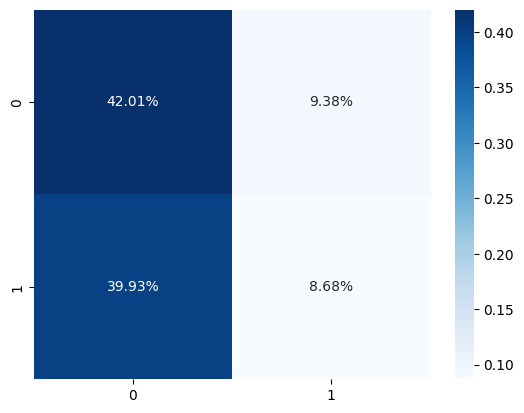

In [ ]:
import sklearn.metrics
import seaborn as sns

def confusion_matrix(model, test_loader):
    preds = []
    targets = []
    clean_targets = []
    clean_preds = []
    with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          #test_loss += nn.functional.binary_cross_entropy(output, target).item()
          pred = output.round().cpu().detach().numpy()
          target = target.cpu().numpy()
          acc = metrics.accuracy_score(target,pred)
          preds.append(pred)
          targets.append(target)
          #test_acc_list.append(acc)#torch.mean(acc).item()
          #sample_eval+= target.shape[0]
      for i in targets:
        for y in i:
          clean_targets.append(y[0])
      for x in preds:
        for z in x:
          clean_preds.append(z[0])

      cf_matrix = sklearn.metrics.confusion_matrix(clean_targets, clean_preds)
      labels = ['True Neg','False Pos','False Neg','True Pos']
      labels = np.asarray(labels).reshape(2,2)
      #sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
      sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
      fmt='.2%', cmap='Blues')
confusion_matrix(model,test_loader)


#test_idx_list

### Inter subject generalizability

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="CNN EEG BASELINE",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "shallow cnn new labels 8",
    "dataset": "EEG",
    "epochs": 500,
    }
)

test acc,██▆▆▆▁▇▆▆▃▅▃▃▄▂▃▅▄▃▆▄▄▄▃▃▃▃▃▄▅▅▄▁▄█▆▅▂▃▂
train epoch acc,█▇█▂▂▃▂▁▂▂▂▂▁▂▁▃▂▂▃▃▂▂▃▂▃▁▂▃▃▄▂▁▃▃▁▂▃▂▃▂
test acc,0.4625
train epoch acc,0.49428


In [ ]:
# Define the number of folds and batch size
#k_folds = 2
batch_size = 64

#rs = ShuffleSplit(n_splits=1, test_size=.1)
# Loop through each fold
test_idx_list = []
for fold, (train_idx, test_idx) in enumerate(zip([np.array([np.int64(i) for i in range(2592)])], [np.array([np.int64(i) for i in range(2592,2880)])])):
    test_idx_list.append(test_idx)
    #print(len(train_idx), len(test_idx), train_idx, test_idx)
    print(f"Fold {fold + 1}")
    print("-------")
    all_accs_train = []
    all_loss_train = []
    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=eeg_PSD_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )

    test_loader = DataLoader(
        dataset=eeg_PSD_dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # Initialize the model and optimizer
    model_inter = Net().to(device)
    optimizer = optim.Adam(model_inter.parameters(), lr=0.001, weight_decay=1e-5) #betas=(0.5, 0.99))
    #scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 200, gamma = 0.5)

    # Train the model on the current fold
    for i in range(30):
      for epoch in tqdm(range(1, 30)):
          train_accuracies, loss = train(model, device, train_loader, optimizer, epoch)
          all_accs_train.append(np.mean(train_accuracies))
          all_loss_train.append(loss)
          #wandb.log({"train acc": train_accuracies[-1]})
          # Evaluate the model on the test set
          model_inter.eval()
          test_loss = 0
          correct = 0
          sample_eval = 0
          test_acc_list = []
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  output = model(data)
                  test_loss += nn.functional.binary_cross_entropy(output, target).item()
                  pred = output.round().cpu().detach().numpy()
                  target = target.cpu().numpy()
                  acc = metrics.accuracy_score(target,pred)
                  test_acc_list.append(acc)#torch.mean(acc).item()
                  sample_eval+= target.shape[0]
              wandb.log({"test acc": np.mean(test_acc_list)}) #"test loss": loss})

      print(all_accs_train[-1])
          #scheduler1.step()
          #print(scheduler1.get_last_lr())

      test_loss /= sample_eval
      accuracy = np.mean(test_acc_list)
      print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: ({accuracy:.2f}%)\n")
       # Mark the run as finished
wandb.finish()

Fold 1
-------


100%|██████████| 29/29 [00:09<00:00,  2.98it/s]


0.504954268292683
Test set: Average loss: 0.0121, Accuracy: (0.46%)



100%|██████████| 29/29 [00:07<00:00,  3.86it/s]


0.5015243902439024
Test set: Average loss: 0.0121, Accuracy: (0.52%)



100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


0.49809451219512196
Test set: Average loss: 0.0120, Accuracy: (0.51%)



100%|██████████| 29/29 [00:07<00:00,  3.97it/s]


0.5053353658536586
Test set: Average loss: 0.0121, Accuracy: (0.47%)



100%|██████████| 29/29 [00:07<00:00,  3.86it/s]


0.49390243902439024
Test set: Average loss: 0.0121, Accuracy: (0.49%)



100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


0.5034298780487805
Test set: Average loss: 0.0121, Accuracy: (0.46%)



100%|██████████| 29/29 [00:07<00:00,  3.86it/s]


0.4961890243902439
Test set: Average loss: 0.0120, Accuracy: (0.51%)



100%|██████████| 29/29 [00:06<00:00,  4.19it/s]


0.48551829268292684
Test set: Average loss: 0.0120, Accuracy: (0.51%)



100%|██████████| 29/29 [00:07<00:00,  3.97it/s]


0.49390243902439024
Test set: Average loss: 0.0120, Accuracy: (0.50%)



100%|██████████| 29/29 [00:08<00:00,  3.28it/s]


0.5118140243902439
Test set: Average loss: 0.0121, Accuracy: (0.48%)



100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


0.504954268292683
Test set: Average loss: 0.0121, Accuracy: (0.51%)



100%|██████████| 29/29 [00:07<00:00,  3.96it/s]


0.5026676829268293
Test set: Average loss: 0.0120, Accuracy: (0.50%)



100%|██████████| 29/29 [00:07<00:00,  3.93it/s]


0.510670731707317
Test set: Average loss: 0.0120, Accuracy: (0.52%)



100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


0.4958079268292683
Test set: Average loss: 0.0120, Accuracy: (0.51%)



100%|██████████| 29/29 [00:07<00:00,  3.86it/s]


0.4916158536585366
Test set: Average loss: 0.0121, Accuracy: (0.48%)



100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


0.5045731707317073
Test set: Average loss: 0.0120, Accuracy: (0.49%)



100%|██████████| 29/29 [00:07<00:00,  3.88it/s]


0.4885670731707317
Test set: Average loss: 0.0120, Accuracy: (0.51%)



100%|██████████| 29/29 [00:07<00:00,  3.90it/s]


0.5072408536585366
Test set: Average loss: 0.0121, Accuracy: (0.44%)



100%|██████████| 29/29 [00:07<00:00,  4.07it/s]


0.4847560975609756
Test set: Average loss: 0.0120, Accuracy: (0.52%)



100%|██████████| 29/29 [00:07<00:00,  3.89it/s]


0.4969512195121951
Test set: Average loss: 0.0121, Accuracy: (0.49%)



100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


0.4992378048780488
Test set: Average loss: 0.0120, Accuracy: (0.54%)



100%|██████████| 29/29 [00:07<00:00,  3.91it/s]


0.4927591463414634
Test set: Average loss: 0.0120, Accuracy: (0.50%)



100%|██████████| 29/29 [00:07<00:00,  3.81it/s]


0.4950457317073171
Test set: Average loss: 0.0121, Accuracy: (0.49%)



100%|██████████| 29/29 [00:06<00:00,  4.18it/s]


0.5003810975609756
Test set: Average loss: 0.0120, Accuracy: (0.47%)



100%|██████████| 29/29 [00:07<00:00,  3.86it/s]


0.4881859756097561
Test set: Average loss: 0.0120, Accuracy: (0.49%)



100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


0.49847560975609756
Test set: Average loss: 0.0120, Accuracy: (0.52%)



100%|██████████| 29/29 [00:07<00:00,  3.86it/s]


0.49009146341463417
Test set: Average loss: 0.0121, Accuracy: (0.46%)



100%|██████████| 29/29 [00:07<00:00,  4.00it/s]


0.5030487804878049
Test set: Average loss: 0.0121, Accuracy: (0.48%)



100%|██████████| 29/29 [00:07<00:00,  3.69it/s]


0.4946646341463415
Test set: Average loss: 0.0121, Accuracy: (0.51%)



100%|██████████| 29/29 [00:07<00:00,  3.91it/s]


0.4954268292682927
Test set: Average loss: 0.0120, Accuracy: (0.50%)



test acc,▆▇▂▅▅▅▄▁▆▆▅▄█▅▃▅▄▄▄▂▃▄██▅▃▄▅▇█▂▆▃▃▆▃▆▄▃▄
train epoch acc,▅██▁▂▆▇▆▅▅▄▆▂▄▅▄▅▁▄▆▅▆▅▂▃▅▆▄▆▄▂▄▆▄▅▃▄█▅▄
test acc,0.5
train epoch acc,0.49543


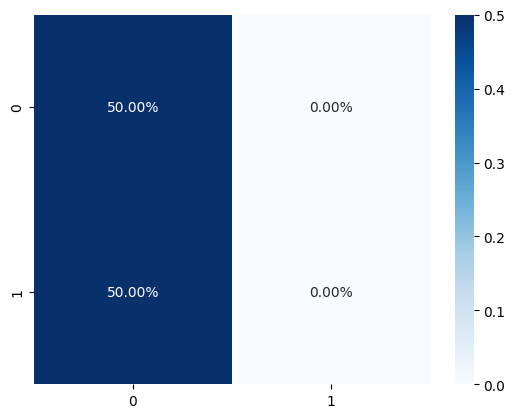

In [ ]:
import sklearn.metrics
import seaborn as sns

def confusion_matrix(model, test_loader):
    preds = []
    targets = []
    clean_targets = []
    clean_preds = []
    with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          #test_loss += nn.functional.binary_cross_entropy(output, target).item()
          pred = output.round().cpu().detach().numpy()
          target = target.cpu().numpy()
          acc = metrics.accuracy_score(target,pred)
          preds.append(pred)
          targets.append(target)
          #test_acc_list.append(acc)#torch.mean(acc).item()
          #sample_eval+= target.shape[0]
      for i in targets:
        for y in i:
          clean_targets.append(y[0])
      for x in preds:
        for z in x:
          clean_preds.append(z[0])

      cf_matrix = sklearn.metrics.confusion_matrix(clean_targets, clean_preds)
      labels = ['True Neg','False Pos','False Neg','True Pos']
      labels = np.asarray(labels).reshape(2,2)
      #sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
      sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
      fmt='.2%', cmap='Blues')
confusion_matrix(model_inter,test_loader)


#test_idx_list

### Spatial GNN

In [ ]:
!pip install torch-geometric
!pip install tensorboardX

In [ ]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
import itertools
from tensorboardX import SummaryWriter
from datetime import datetime

Inspiration: https://www.youtube.com/watch?v=-UjytpbqX4A&ab_channel=LindseyAI

In [ ]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
          self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 100),
            nn.Dropout(0.1),
            nn.BatchNorm1d(100),
            nn.Linear(100, hidden_dim),nn.Dropout(0.1),
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.1
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        x = self.post_mp(x)

        return emb, F.sigmoid(x)

    def loss(self, pred, label):
        label = label.unsqueeze(1)
        return F.binary_cross_entropy(pred.float(), label.float())

In [ ]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.9)], batch_size=32, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.9):], batch_size=32, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # build model
    model = GNNStack(max(30, 1), 32, 1, task=task)
    opt = optim.Adam(model.parameters(), lr=0.0001)

    # train
    for epoch in range(900):
        total_loss = 0
        model.train()
        correct = 0
        size = 0
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            pred_labels = torch.Tensor(pred.round()).squeeze(1)
            correct += pred_labels.eq(label).sum().item()
            size += pred_labels.shape[0]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        wandb.log({"train acc": (correct/size) * 100})
        #writer.add_scalar("loss", total_loss, epoch)
        #print('train acc ', correct/size)
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            #writer.add_scalar("test accuracy", test_acc, epoch)
            wandb.log({"test acc": test_acc})


    return model, test_loader


In [ ]:
def test(loader, model, is_validation=True):

    model.eval()
    list_acc = []
    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            #print(pred)
            pred_labels = torch.Tensor(pred.round()).squeeze(1)
            label = data.y
            pred = output.round().cpu().detach().numpy()
            target = label.cpu().numpy()
            acc = metrics.accuracy_score(target,pred)
            list_acc.append(acc)
        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]

    if model.task == 'graph':
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return np.mean(list_acc)

In [ ]:

def load_graph_data():
    # Load labels and features
    y = np.load('/content/label_based_on_movie_classification.npy')
    x = np.load('/content/eeg_data_no_neutral_PSD_gamma.npy')
    #print(x.shape)
    # Convert to PyTorch tensors
    y = torch.tensor(y, dtype=torch.float32)
    x = torch.tensor(x, dtype=torch.float32)
    y = y.type(torch.LongTensor)

    edge_list = []
    for i in range(1,9):
      combs = itertools.combinations(range(4*(i-1),4*i), 2)
      for z in list(combs):
        edge_list.append(z)

    # fully connected graph for each graph
    edge_index = list(itertools.combinations(range(32), 2))
    edge_index = edge_list
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create a list of Data objects
    data_list = [Data(x=x[i], edge_index=edge_index, y=y[i]) for i in range(x.shape[0])]
    print(len(data_list))

    print(data_list[0].x.shape)
    return data_list

In [ ]:
data = load_graph_data()

2880
torch.Size([32, 30])


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="GNN EEG BASELINE",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "GNN Dense intra local neighbourhood 1",
    "dataset": "EEG",
    "epochs": 900,
    }
)

In [ ]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = data
task = 'graph'

model_gnn, new_test_loader= train(dataset, task, writer)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 0.7082. Test accuracy: 0.5208
Epoch 10. Loss: 0.6983. Test accuracy: 0.4931
Epoch 20. Loss: 0.6970. Test accuracy: 0.4722
Epoch 30. Loss: 0.6944. Test accuracy: 0.5278
Epoch 40. Loss: 0.6952. Test accuracy: 0.4722
Epoch 50. Loss: 0.6959. Test accuracy: 0.4931
Epoch 60. Loss: 0.6942. Test accuracy: 0.4931
Epoch 70. Loss: 0.6966. Test accuracy: 0.5069
Epoch 80. Loss: 0.6951. Test accuracy: 0.4931
Epoch 90. Loss: 0.6940. Test accuracy: 0.5139
Epoch 100. Loss: 0.6953. Test accuracy: 0.5278
Epoch 110. Loss: 0.6950. Test accuracy: 0.4931
Epoch 120. Loss: 0.6946. Test accuracy: 0.4931
Epoch 130. Loss: 0.6942. Test accuracy: 0.4861
Epoch 140. Loss: 0.6930. Test accuracy: 0.4792
Epoch 150. Loss: 0.6939. Test accuracy: 0.4583
Epoch 160. Loss: 0.6938. Test accuracy: 0.5069
Epoch 170. Loss: 0.6950. Test accuracy: 0.5139
Epoch 180. Loss: 0.6954. Test accuracy: 0.5208
Epoch 190. Loss: 0.6949. Test accuracy: 0.5208
Epoch 200. Loss: 0.6932. Test accuracy: 0.4861
Epoch 210. Loss: 0.6951.

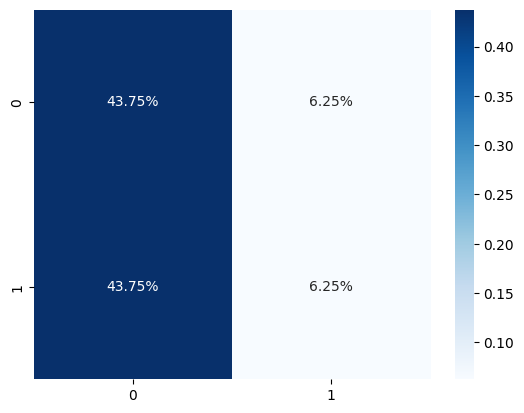

In [ ]:
import sklearn.metrics
import seaborn as sns

def confusion_matrix(model, test_loader):
    preds = []
    targets = []
    clean_targets = []
    clean_preds = []
    with torch.no_grad():
      for data in test_loader:
          target = data.y
          #data, target = data.to(device), target.to(device)
          emb, ouput = model(data)
          #test_loss += nn.functional.binary_cross_entropy(output, target).item()
          pred = output.round().cpu().detach().numpy()
          target = target.cpu().numpy()
          acc = metrics.accuracy_score(target,pred)
          preds.append(pred)
          targets.append(target)
          #test_acc_list.append(acc)#torch.mean(acc).item()
          #sample_eval+= target.shape[0]
      for i in targets:
        for y in i:
          clean_targets.append(y)
      for x in preds:
        for z in x:
          clean_preds.append(z[0])

      cf_matrix = sklearn.metrics.confusion_matrix(clean_targets, clean_preds)
      labels = ['True Neg','False Pos','False Neg','True Pos']
      labels = np.asarray(labels).reshape(2,2)
      #sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
      sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
      fmt='.2%', cmap='Blues')
confusion_matrix(model_gnn,new_test_loader)


#test_idx_list